# Image classification for hand gesture recognition

* **Author:** Cristian Bastidas
* **Last revision:** 2023-04-09

## Data preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images_path = 'images'
! cp '/content/drive/MyDrive/Datasets/HandsPosturev5.zip' HandsPosture.zip
! unzip -q HandsPosture.zip
! mv "HandsPosture" images
! rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


### Data refactoring
Here, we will reorganize all the images for training and then delete all the data that will not be used. Furthermore, each image will have an identifiable name based on its class.

In [ ]:
from os import scandir, listdir, rename
from os.path import isfile, join
from shutil import rmtree, move, copyfile

names = {'B':'play', 'F':'next', 'A':'previous', 'none':'none'}

def get_filenames(folder):
  files = []
  for f in listdir(folder):
      if isfile(join(folder, f)):
        files.append(f)
  return files

def rename_files(folder, s):
  files = get_filenames(folder)
  for f in files:
    rename(join(folder, f), join(folder, s + "_" + f))

def move_files(folder, new_folder):
  files = get_filenames(folder)
  for f in files:
    rename(join(folder, f), join(new_folder, f))

def remove_rename(folder):
  for dir in scandir(folder):
    if dir.name not in list(names.keys()) + list(names.values()):
      rmtree(join(folder, dir.name))
    else:
      try:
        move(join(folder, dir.name), join(folder, names[dir.name]))
        rename_files(join(folder, names[dir.name]), names[dir.name])
      except:
        print(f"{dir.name} already exists")
  print("Unused data was deleted")

remove_rename(images_path)

next already exists
play already exists
previous already exists
Unused data was deleted


### Image samples

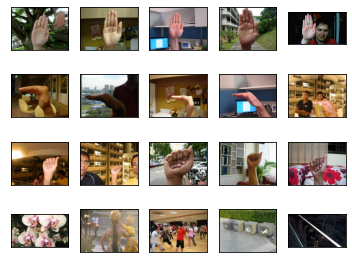

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
n = 5
def show_image(folders, files, name="samples.png"):
  plt.figure(figsize=(1.2*n, 1.2*n))
  for i, img_name in enumerate(files[:n*n]):
    plt.subplot(n,n,i+1)
    plt.xticks([])
    plt.yticks([])
    image = mpimg.imread(join(images_path,folders[i],img_name))
    plt.imshow(image)

si = ["play.jpg", "next.jpg", "prev.jpg"]
folder_play, folder_next, folder_prev, folder_none = names.values()
folders = [folder_play]*n + [folder_next]*n + [folder_prev]*n + [folder_none]*n

files_play = listdir(join(images_path, folder_play))
files_next = listdir(join(images_path, folder_next))
files_prev = listdir(join(images_path, folder_prev))
files_none = listdir(join(images_path, folder_none))

show_image(folders, files_play[:n] + files_next[:n] + files_prev[:n] + files_none[:n])

## Dataset pre-processing
With Keras' image data generator, we can generate batches of images and their labels to obtain more data. Then, we split the data into training and validation sets, respectively, with a ratio of 80% and 20%.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Generador de datos de keras con data augmentation
datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=30,
  horizontal_flip=True,
  #vertical_flip=True,
  width_shift_range=0.1,
  height_shift_range=0.1, 
  brightness_range=[0.4, 1.5],
  shear_range=0.2,
  channel_shift_range=80,
  zoom_range=0.3,
  fill_mode='wrap',
  validation_split=0.2
)

# Datos para entrenamiento
datagen_train = datagen.flow_from_directory(
  images_path,
  target_size=(224, 224),
  batch_size=32,
  shuffle=True,
  subset='training'
)

# Datos para validación
datagen_test = datagen.flow_from_directory(
  images_path,
  target_size=(224, 224),
  batch_size=32,
  shuffle=True,
  subset='validation'
)

Found 896 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


### Data augmentation samples

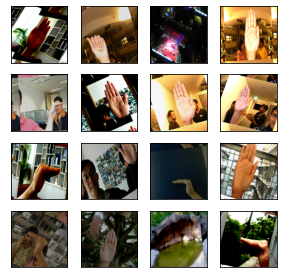

In [ ]:
n = 4
plt.figure(figsize=(1.2*n, 1.2*n))
for image, tag in datagen_train:
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i])
  break
plt.show()

## Training environment test

In [ ]:
import tensorflow as tf
print("TF Version: ", tf.__version__)
print("Eager mode enable: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.8.0
Eager mode enable:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Transfer learning
### Mobilenet v2
We freeze the base model and only train the top layers. We use the ImageNet weights and set the input size to 224x224 with 3 channels.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

mobilenetv2 =  MobileNetV2(
  weights = "imagenet",
  include_top = False,
  input_shape = (224, 224, 3)
)

mobilenetv2.trainable = False

### Training parameters
Let's train the model for 150 epochs with a batch size of 32. We will also adjust the learning rate to 0.0001 and set a dropout value of 20% to avoid overfitting.

In [ ]:
rate_value = 1e-4
train_epochs = 150
train_bsize = 32
dropout_value = 0.2

### Building the model
The base layer will be the pre-trained model, to which we will add a GlobalAveragePooling2D layer. This layer will reduce the input size to a single vector, which will be used as input to the next layer and will allow for easy interpretation of the model.

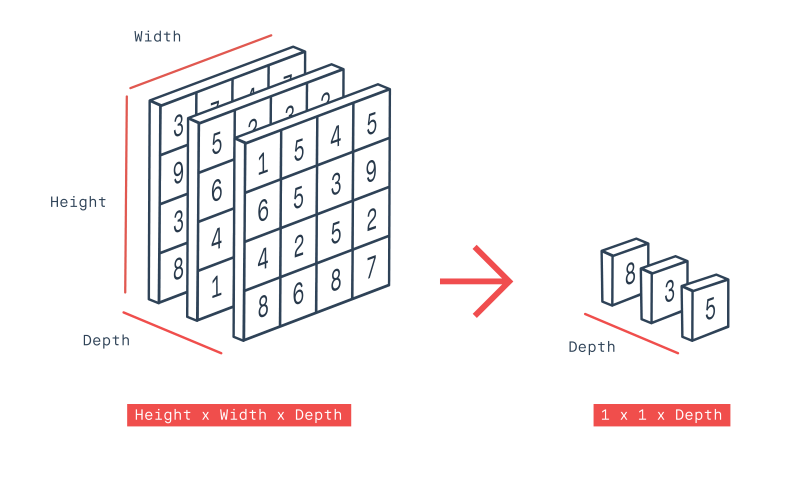

In addition, we add a dropout layer to prevent overfitting by deactivating a certain percentage of neurons, as defined in the training parameters. Finally, we add a dense softmax layer with 4 neurons corresponding to the 4 classes.

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

modelo = mobilenetv2.output
modelo = mobilenetv2(mobilenetv2.input, training=False)
modelo = GlobalAveragePooling2D()(modelo)
modelo = Dropout(dropout_value)(modelo)
modelo = Dense(4, activation='softmax')(modelo)

model = Model(inputs = mobilenetv2.input, outputs = modelo)

### Model compilation
We will use the Adam optimizer with a custom learning rate specified in the training parameters.

In [ ]:
opt = Adam(
  learning_rate = rate_value, 
)

model.compile(
  optimizer = opt,
  loss = 'categorical_crossentropy',
  metrics = ['accuracy']
)

Model layer summary

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainab

Loss and accuracy before training

In [ ]:
# Loss and Accuracy before training
model.evaluate(datagen_test)
print("Trainable variables:", len(model.trainable_variables))

7/7 [==============================] - 6s 553ms/step - loss: 2.1992 - accuracy: 0.2455
Trainable variables: 2


### Training

In [ ]:
hist = model.fit(
  datagen_train,
  epochs = train_epochs,
  batch_size = train_bsize,
  validation_data = datagen_test,
)

Epoch 1/150
28/28 [==============================] - 31s 987ms/step - loss: 1.8165 - accuracy: 0.2266 - val_loss: 1.6896 - val_accuracy: 0.2188
Epoch 2/150
28/28 [==============================] - 20s 705ms/step - loss: 1.6198 - accuracy: 0.2701 - val_loss: 1.4887 - val_accuracy: 0.2500
Epoch 3/150
28/28 [==============================] - 19s 694ms/step - loss: 1.5354 - accuracy: 0.3092 - val_loss: 1.3869 - val_accuracy: 0.3304
Epoch 4/150
28/28 [==============================] - 19s 680ms/step - loss: 1.3850 - accuracy: 0.3862 - val_loss: 1.1941 - val_accuracy: 0.4598
Epoch 5/150
28/28 [==============================] - 20s 722ms/step - loss: 1.3766 - accuracy: 0.3828 - val_loss: 1.1312 - val_accuracy: 0.5268
Epoch 6/150
28/28 [==============================] - 19s 695ms/step - loss: 1.3097 - accuracy: 0.4141 - val_loss: 1.0488 - val_accuracy: 0.5625
Epoch 7/150
28/28 [==============================] - 19s 667ms/step - loss: 1.2364 - accuracy: 0.4688 - val_loss: 0.9877 - val_accuracy:

### Saving the model without fine tuning

In [ ]:
from google.colab import files
model.save('hmc_no_fine_tunning.h5', save_format="h5")
files.download('hmc_no_fine_tunning.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Top layers
To improve the accuracy of the model, we unfreeze the top layers and continue training. This process is known as fine-tuning, and it allows the model to adjust better to certain observations in the dataset. It is important to perform this fine-tuning on the top layers of the model because these layers in convolutional neural networks are specialized.

In [ ]:
mobilenetv2.trainable = True
# Capas disponibles del modelo
print("Number of layers in the base model: ", len(mobilenetv2.layers))

# Ajuste fino desde esta capa
fine_tune_at = 100

# Congela todas las capas después de `fine_tune_at`
for layer in mobilenetv2.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Model re-compiling
Here, we need to decrease the learning rate to avoid overfitting. Additionally, we will change the optimizer to a linear momentum optimizer.

In [ ]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(
  learning_rate = rate_value/10, 
)

model.compile(
  optimizer =opt,
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

Fine tuning model summary

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 1,866,564
Non-tra

All the variables that will be retrained

In [ ]:
print("Trainable variables:", len(model.trainable_variables))

Trainable variables: 56


### Fine Tuning training

In [ ]:
fine_tune_epochs = 50
total_epochs = train_epochs + fine_tune_epochs

history_fine = model.fit(
  datagen_train,
  epochs=total_epochs,
  initial_epoch=hist.epoch[-1],
  validation_data=datagen_test
)

Epoch 150/200
28/28 [==============================] - 27s 720ms/step - loss: 0.2447 - accuracy: 0.9051 - val_loss: 0.1368 - val_accuracy: 0.9554
Epoch 151/200
28/28 [==============================] - 19s 685ms/step - loss: 0.2010 - accuracy: 0.9241 - val_loss: 0.1443 - val_accuracy: 0.9554
Epoch 152/200
28/28 [==============================] - 19s 692ms/step - loss: 0.1774 - accuracy: 0.9353 - val_loss: 0.1259 - val_accuracy: 0.9643
Epoch 153/200
28/28 [==============================] - 19s 683ms/step - loss: 0.1427 - accuracy: 0.9576 - val_loss: 0.1245 - val_accuracy: 0.9643
Epoch 154/200
28/28 [==============================] - 19s 668ms/step - loss: 0.1514 - accuracy: 0.9453 - val_loss: 0.1498 - val_accuracy: 0.9420
Epoch 155/200
28/28 [==============================] - 19s 667ms/step - loss: 0.1234 - accuracy: 0.9565 - val_loss: 0.1483 - val_accuracy: 0.9464
Epoch 156/200
28/28 [==============================] - 19s 676ms/step - loss: 0.1234 - accuracy: 0.9665 - val_loss: 0.0780 -

### Saving the final model

In [ ]:
from google.colab import files
model.save('hmc.h5', save_format="h5")
files.download('hmc.h5')

## Loss and Accuracy plots

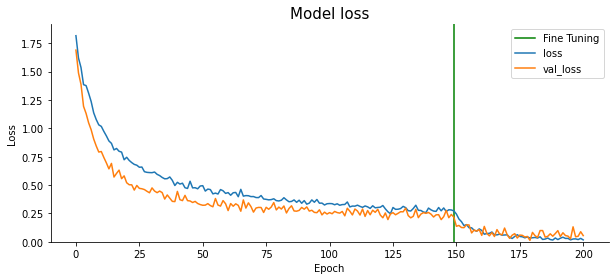

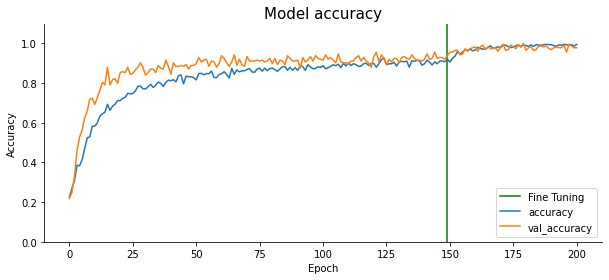

In [ ]:
import pandas as pd
import seaborn as sns
# Loss plot
loss = pd.DataFrame(hist.history)[['loss','val_loss']]
loss_fine = pd.concat(
  [loss, pd.DataFrame(history_fine.history)[['loss','val_loss']]],
  axis=0
)

loss_fine = loss_fine.reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.title("Model loss", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.ylim([0, max(loss_fine.loss) + 0.1])

plt.plot(
  [train_epochs-1,train_epochs-1],
  plt.ylim(),
  label='Fine Tuning',
  color="green"
)

sns.lineplot(data=loss_fine, markers=False, dashes=False)
sns.despine()
plt.show()

print()
# Accuracy plot
accdf = pd.DataFrame(hist.history)[['accuracy','val_accuracy']]
accdf_fine = pd.concat([accdf, pd.DataFrame(history_fine.history)[['accuracy','val_accuracy']]], axis=0)
accdf_fine = accdf_fine.reset_index(drop=True)

plt.figure(figsize=(10,4))
plt.title("Model accuracy", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.ylim([0, max(accdf_fine.accuracy) + 0.1])
plt.plot([train_epochs-1,train_epochs-1],plt.ylim(), label='Fine Tuning', color="green")
sns.lineplot(data=accdf_fine, markers=False, dashes=False)
sns.despine()
plt.show()

## Classification report
Confusion matrix, classification report and classification accuracy

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import seaborn as sns
import pandas as pd

def print_metrics(x, y, model_test):
  target_names = ['next', 'none', 'play/pause', 'previous']
  pred = np.argmax(np.round(model_test.predict(x), 0), axis=1)

  cf_mat = confusion_matrix(y, pred)
  cr = classification_report(y, pred, target_names=target_names)

  df_cm = pd.DataFrame(
      cf_mat, index=target_names, columns=target_names, 
  )

  fig = plt.figure(figsize=(5,4))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="g", cmap='Blues')
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)
  plt.ylabel('Actual value')
  plt.xlabel('Prediction value')
  plt.show()

  print()
  print(cr)
  print()

  #[None, 'micro', 'macro', 'weighted', 'samples]
  accuracy = accuracy_score(y, pred)
  print('Accuracy: %f' % accuracy)

  precision = precision_score(y, pred, average=None)
  print('Precision:', precision)

  recall = recall_score(y, pred, average=None)
  print('Recall:', recall)

  f1 = f1_score(y, pred, average=None)
  print('F1 score:', f1)

In [ ]:
from keras.models import load_model
model_before = load_model('hmc_no_fine_tunning.h5')
model_before.build((None, 224, 224, 3))

### Before fine tuning

#### Training report

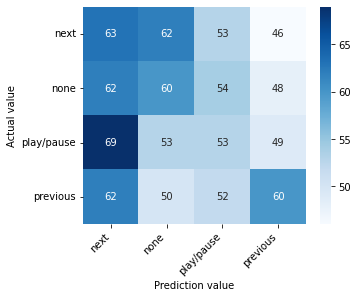


              precision    recall  f1-score   support

        next       0.25      0.28      0.26       224
        none       0.27      0.27      0.27       224
  play/pause       0.25      0.24      0.24       224
    previous       0.30      0.27      0.28       224

    accuracy                           0.26       896
   macro avg       0.26      0.26      0.26       896
weighted avg       0.26      0.26      0.26       896


Accuracy: 0.263393
Precision: [0.24609375 0.26666667 0.25       0.2955665 ]
Recall: [0.28125    0.26785714 0.23660714 0.26785714]
F1 score: [0.2625     0.26726058 0.24311927 0.28103044]


In [ ]:
print_metrics(datagen_train, datagen_train.classes, model_before)

#### Testing report

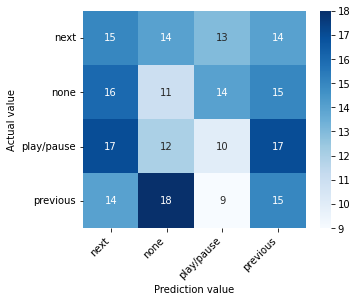


              precision    recall  f1-score   support

        next       0.24      0.27      0.25        56
        none       0.20      0.20      0.20        56
  play/pause       0.22      0.18      0.20        56
    previous       0.25      0.27      0.26        56

    accuracy                           0.23       224
   macro avg       0.23      0.23      0.23       224
weighted avg       0.23      0.23      0.23       224


Accuracy: 0.227679
Precision: [0.24193548 0.2        0.2173913  0.24590164]
Recall: [0.26785714 0.19642857 0.17857143 0.26785714]
F1 score: [0.25423729 0.1981982  0.19607843 0.25641026]


In [ ]:
print_metrics(datagen_test, datagen_test.classes, model_before)

### With fine tunning

#### Training report

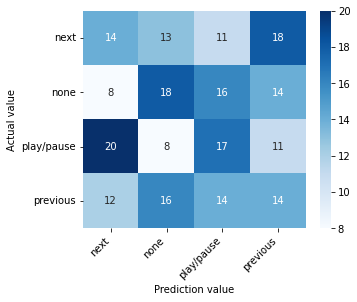


              precision    recall  f1-score   support

        next       0.26      0.25      0.25        56
        none       0.33      0.32      0.32        56
  play/pause       0.29      0.30      0.30        56
    previous       0.25      0.25      0.25        56

    accuracy                           0.28       224
   macro avg       0.28      0.28      0.28       224
weighted avg       0.28      0.28      0.28       224


Accuracy: 0.281250
Precision: [0.25925926 0.32727273 0.29310345 0.24561404]
Recall: [0.25       0.32142857 0.30357143 0.25      ]
F1 score: [0.25454545 0.32432432 0.29824561 0.24778761]


In [ ]:
print_metrics(datagen_test, datagen_test.classes, model)

#### Testing report

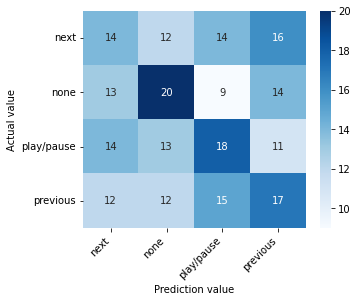


              precision    recall  f1-score   support

        next       0.26      0.25      0.26        56
        none       0.35      0.36      0.35        56
  play/pause       0.32      0.32      0.32        56
    previous       0.29      0.30      0.30        56

    accuracy                           0.31       224
   macro avg       0.31      0.31      0.31       224
weighted avg       0.31      0.31      0.31       224


Accuracy: 0.308036
Precision: [0.26415094 0.35087719 0.32142857 0.29310345]
Recall: [0.25       0.35714286 0.32142857 0.30357143]
F1 score: [0.25688073 0.3539823  0.32142857 0.29824561]


In [ ]:
print_metrics(datagen_test, datagen_test.classes, model)

## Model evaluation

In [ ]:
import requests
import tensorflow_hub as hub
from io import BytesIO
from PIL import Image
import numpy as np

import cv2

reloaded_model = load_model('hmc.h5')

#print(reloaded_model.get_config())
reloaded_model.summary()
reloaded_model.build((None, 224, 224, 3))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 1,866,564
Non-tra

### Evaluating from the internet

In [ ]:
def download_and_test(url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224, 224))
  pred = reloaded_model.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(pred[0], axis=-1)

def test(url):
  reloaded_model.build((None, 224, 224, 3))
  img = Image.open(url)
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224, 224))
  pred = reloaded_model.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(pred[0], axis=-1)

### Evaluation results

In [ ]:
# 0 Next
url = 'https://previews.123rf.com/images/arybickii/arybickii1510/arybickii151000428/46653306-dedo-ortograf%C3%ADa-el-alfabeto-en-lenguaje-de-se%C3%B1as-americano-asl-la-letra-g.jpg'
pred = download_and_test(url)
print(pred)

# 1 None
url = 'https://mymodernmet.com/wp/wp-content/uploads/2020/02/Landscape-Photographer-of-the-Year-Sander-Grefte.jpg'
pred = download_and_test(url)
print(pred)

# 2 Play
url = 'https://www.lifeprint.com/asl101/signjpegs/b/b1.jpg'
pred = download_and_test(url)
print(pred)

# 3 Prev
url = 'https://www.lifeprint.com/asl101/signjpegs/a/a.jpg'
pred = download_and_test(url)
print(pred)

0
1
2
3


## Conclusion
Even though the dataset was originally prepared with the three necessary classes for the scenario, the implementation proved to be unstable. Some images from certain classes were sometimes recognized as random images. As a solution, we added the class 'none' to introduce noise into the model and improve its performance in the final implementation.

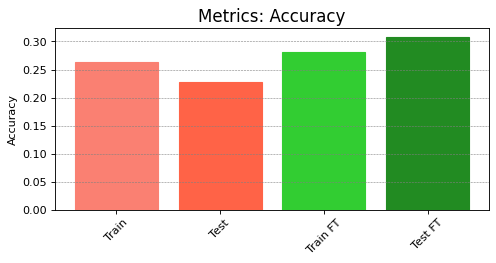

In [ ]:
labels = ['Train', 'Test', 'Train FT', 'Test FT']
values = [0.263393, 0.227679, 0.281250, 0.308036]
colors = ['salmon', 'tomato', 'limegreen', 'forestgreen']

plt.figure(figsize=(7,3), dpi=80)
plt.title("Metrics: Accuracy", fontsize=15)

plt.xticks(rotation=45)
plt.ylabel("Accuracy")

plt.grid(axis = 'y', color='gray', linestyle = '--', linewidth = 0.5)

bar_list = plt.bar(labels, values, color='green')
for i, bar in enumerate(bar_list):
  bar.set_color(colors[i])

plt.show()

The graph presented shows a comparison of the 'accuracy' metric in the classification report between the model without fine-tuning and the model with fine-tuning in both training and validation. The results indicate an 8% improvement in validation, demonstrating that fine-tuning has indeed enhanced the model's performance. Additionally, there was a 2% improvement in training.

Regarding the confusion matrix, the first three classification reports revealed a class imbalance. However, with fine-tuning in validation, the matrix shows a better diagonal, indicating that the model has improved in comparison to its non-fine-tuned version.